# Exploration et nettoyage des données

## Concaténation des données

Les données proviennent d'une interface web permettant d'obtenir des données de **stackoverflow** en SQL.
Nous avons executé la requête suivante pour obtenir nos données:

`SELECT p.*
FROM Posts as p
inner join posttags as pt on p.id = pt.postid
WHERE p.PostTypeId = 1 AND p.ViewCount > 5
AND p.Score > 5 AND p.AnswerCount > 0 
group by pt.postid having count(pt.tagid)>3`

Nous ne prenons que les questions ayant plus de trois tags, un viewcount supérieur à 5 et un score supérieur à 5.
Cette requête a 536179 résultats, mais le système limite les résultats à 50000 lignes. On execute donc 11 requêtes et on commence par concaténer les résultats.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [22]:
import pandas as pd

import os

result_dfs = []
for path in os.listdir('./query_results'):
    result_dfs.append(pd.read_csv(os.path.join('./query_results/',path), index_col='Id'))

df = pd.concat(result_dfs)
df


,Title,Body,Tags,Score,ViewCount,AnswerCount,nbtags
Id,,,,,,,
56876342,Chrome Save as PDF changing CJK characters,<p>We are seeing an issue when we try to save ...,<html><google-chrome><pdf><unicode>,9,862,1,4
56876620,Unsure how to use colormap with Folium marker ...,"<p>I have a dataframe with latitude, longitude...",<python><pandas><colormap><folium>,10,11855,1,4
56876783,How to correctly import BillingResponse with n...,<p>I'm upgrading my version of android billing...,<java><android><gradle><in-app-billing>,9,2630,2,4
56876817,PytestDeprecationWarning at test setup: the fu...,"<p>Following tutorial on <a href=""https://test...",<python><django><pytest><django-channels>,7,1340,1,4
56876823,Put the legend of pandas bar plot with seconda...,<p>I have a pandas DataFrame with a secondary ...,<python><pandas><matplotlib><plot><jupyter-not...,6,1474,1,5
...,...,...,...,...,...,...,...
38926965,"Invalid VirtualBox parameter ""–cpuidset""",<p>I want to add the OS X El Capitan to my Vir...,<macos><cmd><virtual-machine><virtualbox>,7,14522,3,4
38927124,Computing Signature/Hash in Javascript and hav...,<p>I have the following code in C#</p>\n\n<pre...,<javascript><c#><hash><sha256><cryptojs>,7,4197,1,5
38927230,"Panda AssertionError columns passed, passed da...",<p>I am working on Azure ML implementation on ...,<python><pandas><dataframe><nltk><azure-machin...,7,53272,1,5


## Séparation des textes et codes des questions

Les questions de stackoverflow sont presque toujours composées d'un texte en langage naturel, et d'un ou plusieurs blocs de code dans différents langages de programmation ou de configuration.

Nous avons l'intuition que:
- Les modèles de NLP ne fonctionneront pas de la même manière sur le texte et le code
- Que le code et le texte ont tous les deux une grande importance pour déterminer les tags correspondant à une question.

Nous prenons donc le parti de séparer le texte et le code, et nous entrainerons pour chaque architecture deux modèles, un pour le code et un pour le texte, et évaluerons les différentes combinaisons possibles des résultats de ces modèles.

Nous nous basons sur les balises `<code>` pour déterminer le code et le texte dans nos questions.

In [28]:
from bs4 import BeautifulSoup
from markdown import markdown

def get_text_and_code(body):
    html = markdown(body)
    bs = BeautifulSoup(html)
    codes = bs.findAll('code')
    code = '\n'.join([x.text for x in codes])
    for x in codes:
        x.decompose()
    text = '\n'.join(bs.findAll(text=True))
    return pd.Series({"text":text, "code":code})
df = df.join(df.Body.apply(get_text_and_code))

In [29]:
df.isna().sum()

Title          0
Body           0
Tags           0
Score          0
ViewCount      0
AnswerCount    0
nbtags         0
tag_set        0
tag_list       0
text           0
code           0
dtype: int64

In [30]:
df.to_csv("./questions_with_tags_texts_codes.csv")

## Etude et sélection des tags

On commence par créer un set et une liste de tags pour chaque question.

In [23]:
df['tag_set'] = df.Tags.apply(lambda x: set(x[1:-1].split('><')))
df['tag_list'] = df.Tags.apply(lambda x: x[1:-1].split('><'))


In [24]:
df.tag_list


Id
56876342                  [html, google-chrome, pdf, unicode]
56876620                   [python, pandas, colormap, folium]
56876783              [java, android, gradle, in-app-billing]
56876817            [python, django, pytest, django-channels]
56876823    [python, pandas, matplotlib, plot, jupyter-not...
                                  ...                        
38926965            [macos, cmd, virtual-machine, virtualbox]
38927124             [javascript, c#, hash, sha256, cryptojs]
38927230    [python, pandas, dataframe, nltk, azure-machin...
38927267    [spring, spring-mvc, spring-security, spring-b...
38927302    [android, android-layout, android-studio, mate...
Name: tag_list, Length: 536179, dtype: object

<AxesSubplot:ylabel='Frequency'>

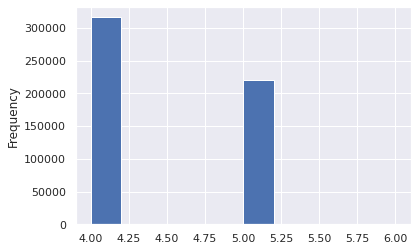

In [25]:
df.nbtags.plot.hist()

Toutes nos questions ont quatre ou cinq tags.

In [26]:
stack = df.tag_list.apply(pd.Series).stack()
stack


Id         
56876342  0                       html
          1              google-chrome
          2                        pdf
          3                    unicode
56876620  0                     python
                        ...           
38927302  0                    android
          1             android-layout
          2             android-studio
          3            material-design
          4    android-support-library
Length: 2364694, dtype: object

Nous allons  étudier la distribution des tags dans nos questions.

<AxesSubplot:>

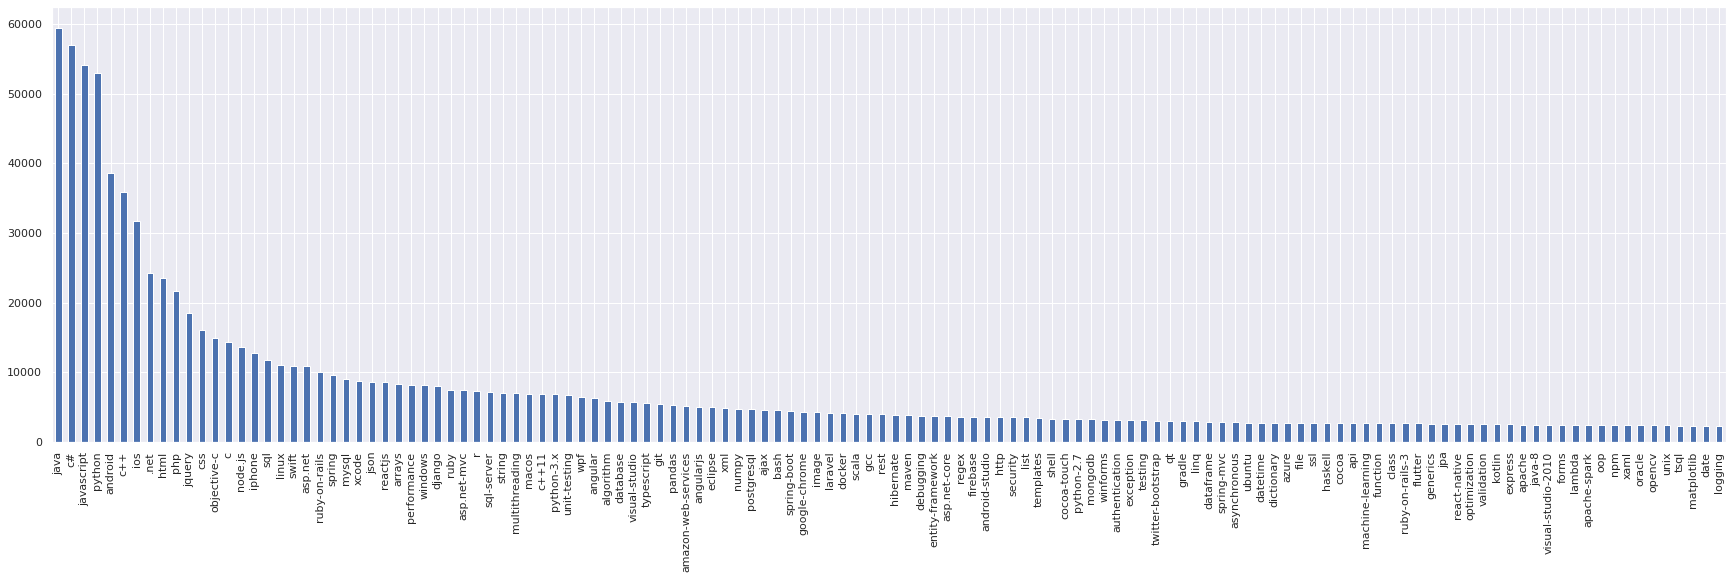

In [27]:
stack.value_counts().iloc[0:128].plot.bar(figsize=(30,8))

Les tags ne sont pas répartis de manière uniforme, le plus fréquent apparait 60000 fois alors que le moins fréquent a autour de 2500 occurrences.

Nous choisissons arbitrairement de travailler sur les 16 tags les plus fréquents qui ont tous plus de 10000 occurrences

In [31]:
selected_tags = set(stack.value_counts().iloc[0:16].index)

## Echantillonnage des données et division des jeux de travail

Pour avoir un échantillon de travail limitant le biais induit par le déséquilibre entre la taille des classes, nous échantillonnons 10000 questions par tag, en fausant bien attention à supprimer les doublons.

In [32]:
sample_df = pd.concat([df[df.tag_list.apply(lambda x: tag in x)].sample(
    10000) for tag in selected_tags])
sample_df.tag_set = sample_df.tag_set.astype(str)
sample_df.tag_list = sample_df.tag_list.astype(str)
sample_df.drop_duplicates(inplace=True)
sample_df.tag_set = sample_df.tag_set.apply(eval)
sample_df.tag_list = sample_df.tag_list.apply(eval)
sample_df

,Title,Body,Tags,Score,ViewCount,AnswerCount,nbtags,tag_set,tag_list,text,code
Id,,,,,,,,,,,
21744539,Cannot open custom file extension,"<p>I have a file format I wish to support, it'...",<android><android-activity><android-manifest><...,8,3017,1,4,"{android, android-activity, android-manifest, ...","[android, android-activity, android-manifest, ...","I have a file format I wish to support, it's j...","<activity\n android:name=""com.test...."
37371990,How can I send a Firebase Cloud Messaging noti...,<p>I'm starting with the new Google service fo...,<php><android><firebase><firebase-cloud-messag...,249,426055,17,4,"{android, firebase, php, firebase-cloud-messag...","[php, android, firebase, firebase-cloud-messag...",I'm starting with the new Google service for t...,Firebase Cloud Messaging
30481871,Android Spinner not working on Samsung Devices...,<p>I'm using a custom Spinner widget with the ...,<java><android><spinner><android-5.0-lollipop>,6,2190,1,4,"{java, android, spinner, android-5.0-lollipop}","[java, android, spinner, android-5.0-lollipop]",I'm using a custom Spinner widget with the cod...,"<?xml version=""1.0"" encoding=""utf-8""?>\n\n<Spi..."
29840394,Getting position of View in onCreateViewHolder,<p>I am using a RecyclerView with a single row...,<java><android><android-view><android-recycler...,23,25360,3,5,"{android, android-view, android-viewholder, ja...","[java, android, android-view, android-recycler...",I am using a RecyclerView with a single row la...,public class CommentAdapter extends RecyclerVi...
15520640,Displaying a fan page in a UIWebView with an a...,<p>We're developing an app for iOS and Android...,<android><objective-c><uiwebview><access-token...,6,321,1,5,"{android, access-token, uiwebview, facebook-pa...","[android, objective-c, uiwebview, access-token...",We're developing an app for iOS and Android th...,UIWebView\nUIWebView
...,...,...,...,...,...,...,...,...,...,...,...
33936124,pypeg2 - can this expression be parsed using p...,<p>I need to parse expressions based on follow...,<python><regex><parsing><grammar><peg>,8,1411,1,5,"{grammar, regex, parsing, peg, python}","[python, regex, parsing, grammar, peg]",I need to parse expressions based on following...,name:value\nfilter1:45 hello world filter:5454...
701429,Library/tool for drawing ternary/triangle plots,"<p>I need to draw <a href=""http://en.wikipedia...",<python><r><plot><gnuplot>,16,14731,9,4,"{gnuplot, r, python, plot}","[python, r, plot, gnuplot]",I need to draw \nternary/triangle plots\n repr...,
16685384,Finding the indices of matching elements in li...,<p>I have a long list of float numbers ranging...,<python><list><indexing><find>,47,146553,3,4,"{list, indexing, find, python}","[python, list, indexing, find]",I have a long list of float numbers ranging fr...,"def find(lst,a,b):\n result = []\n for x..."


Et on obtient un ensemble de 141197 questions.

On divise ensuite notre jeu en trois sous ensembles:
- 10% pour la validation
- 15% pour le test
- 75% pour l'entraînement

Et on enregistre chacun de nos jeux pour que chaque modèle étudié travaille sur exactement les mêmes jeux de données.

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np
import json
def split_data(dataframe):
    df_to_split, df_validation, = train_test_split(
        dataframe, test_size=0.1)
    df_train, df_test = train_test_split(
        df_to_split, test_size=0.17)
    return df_train, df_test, df_validation


In [34]:
sample_train, sample_test, sample_validation = split_data(
    sample_df)

# sample_train.to_csv('./train.csv', index=False)
# sample_test.to_csv('./test.csv', index=False)
# sample_validation.to_csv('./validation.csv', index=False)
with open("selected_tags.json", "w") as outfile:
   json.dump(list(selected_tags), outfile)


## Distribution des tags dans les différents jeux

Etant donné qu'une question peut avoir différent tags, nous garantissons que nous avons au moins 10000 occurrences de chaque tags dans notre jeu total, mais certains tags les plus communs se retrouvent beaucoup plus présents dans nos données.

Nous avons trouvés des papiers décrivant des algorithmes itératifs pour obtenir des classes équilibrées dans le cas d'une classification multilabels, mais cela n'étant pas vraiment le sujet de ce projet, et nos décalages restant relativement limités, nous décidons de garder nos données avec les décalages.

Les décalages sont à peu près identiques dans chacun des jeux de travail.

Total data:
(141197, 11)


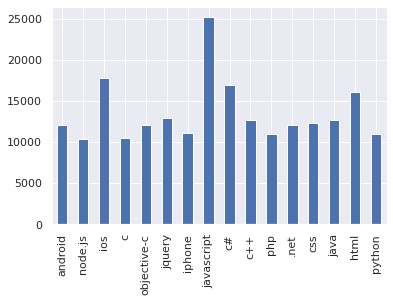

In [35]:
print("Total data:")
print(sample_df.shape)
tag_df = pd.DataFrame()
for tag in selected_tags:
    tag_df[tag] = sample_df.tag_set.apply(
        lambda x: 1 if tag in x else 0)
tag_df.loc[:, list(selected_tags)].sum().plot.bar();



Training set:
(105473, 11)


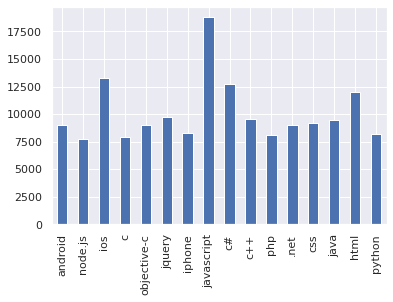

In [36]:

print("Training set:")
print(sample_train.shape)
tag_df = pd.DataFrame()
for tag in selected_tags:
    tag_df[tag] = sample_train.tag_set.apply(
        lambda x: 1 if tag in x else 0)
tag_df.loc[:, list(selected_tags)].sum().plot.bar();


Test set:
(21604, 11)


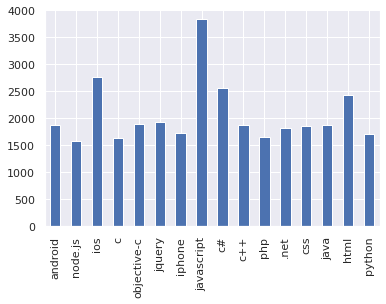

In [37]:


print("Test set:")
print(sample_test.shape)
tag_df = pd.DataFrame()
for tag in selected_tags:
    tag_df[tag] = sample_test.tag_set.apply(
        lambda x: 1 if tag in x else 0)
tag_df.loc[:, list(selected_tags)].sum().plot.bar();


Validation set:
(14120, 11)


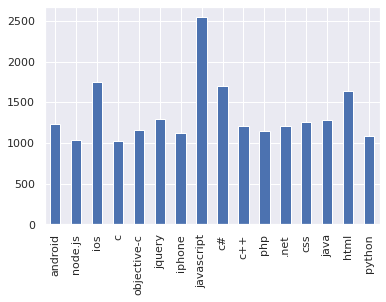

In [38]:

print("Validation set:")
print(sample_validation.shape)
tag_df = pd.DataFrame()
for tag in selected_tags:
    tag_df[tag] = sample_validation.tag_set.apply(
        lambda x: 1 if tag in x else 0)
tag_df.loc[:, list(selected_tags)].sum().plot.bar();


## Etude des distributions du nombre de tokens dans les questions

Pour étudier les tokens, nous commençons par faire un pré-traitement des nos codes et textes, consistant à nettoyer le texte, supprimer les ponctuations et chiffres ainsi que les stopwords, et à lemmatiser nos tokens.

In [39]:
from sklearn.model_selection import train_test_split
import spacy
from tqdm.notebook import tqdm
import numpy as np
from thinc.api import set_gpu_allocator, require_gpu
set_gpu_allocator("pytorch")
require_gpu(0)
nlp = spacy.load('en_core_web_lg')


def preprocess(texts):
    removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT',
               'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
    tokens = []
    cleaned_texts = []
    print("preprocessing")
    for summary in tqdm(nlp.pipe(texts, disable=["tok2vec"]), total=len(texts)):
        question_tokens = []
        for token in summary:
            if token.pos_ not in removal and not token.is_stop and token.is_alpha:
                question_tokens.append(token.lemma_)
        cleaned_texts.append(" ".join(question_tokens))
    # question_tokens = [token.lemma_ for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    return cleaned_texts


sample_df["preprocessed_text"] = preprocess(sample_df.text)
sample_df["preprocessed_code"] = preprocess(sample_df.code)


preprocessing


  0%|          | 0/141197 [00:00<?, ?it/s]

preprocessing


  0%|          | 0/141197 [00:00<?, ?it/s]

Commençons par le nombre de tokens dans les textes.

<AxesSubplot:>

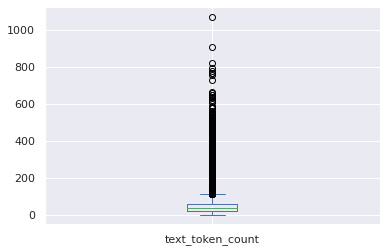

In [40]:
sample_df["text_token_count"] = sample_df["preprocessed_text"].apply(
    lambda x: len(x.split(" ")))
sample_df["text_token_count"].plot.box()


On voit que ce nombre est assez variable. La plupart des textes ont entre 0 et 100 tokens, mais de nombreux outliers ont beaucoup plus.

Observons ensuite le nombre de tokens dans les codes.

<AxesSubplot:>

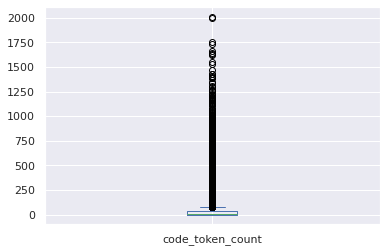

In [41]:
sample_df["code_token_count"] = sample_df["preprocessed_code"].apply(
    lambda x: len(x.split(" ")))
sample_df["code_token_count"].plot.box()


Les nombreux outliers nuisent à la lisibilité, observons la distribution sans outliers.

<AxesSubplot:>

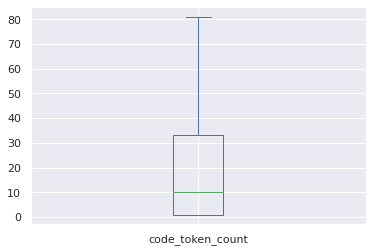

In [42]:
sample_df["code_token_count"].plot.box(showfliers=False)


Dans l'ensemble, les codes ont un peu moins de tokens, avec certains outliers ayant jusqu'à 2000 tokens.

Observons ensuite ces distributions groupées par tags.

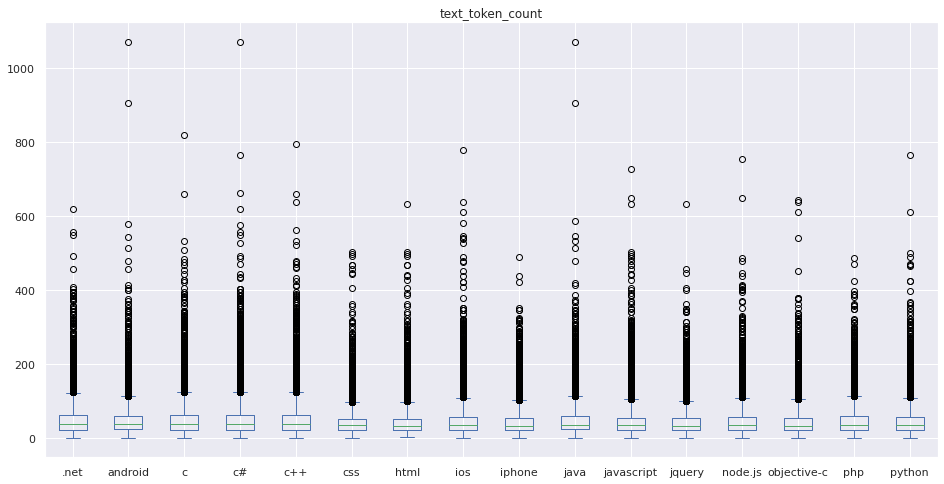

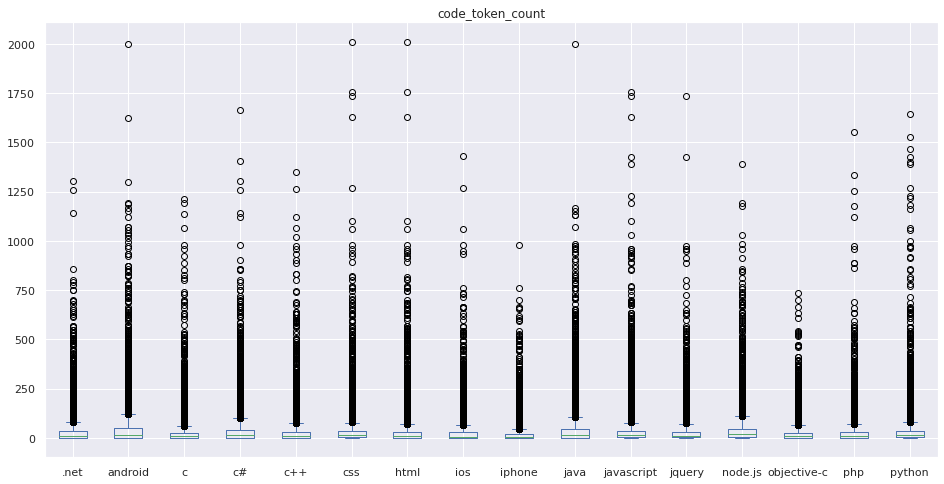

In [46]:
for tag in selected_tags:
    sample_df[tag] = sample_df.tag_set.apply(lambda x: 1 if tag in x else 0)
res = []
for tag in selected_tags:
    tag_df = sample_df[sample_df[tag]==1].loc[:]
    tag_df["tag"] = tag
    res.append(tag_df)

dup_df = pd.concat(res, ignore_index=True)

dup_df.plot.box(column="text_token_count", by="tag", figsize=(16,8));
dup_df.plot.box(column="code_token_count", by="tag", figsize=(16,8));

Tous les tags semblent avoir à peu près les mèmes distributions pour les textes et codes. 

Ces résultats ne nous poussent pas à faire un quelconque nettoyage à ce niveau. Les textes et codes les plus longs seront tronqués pour les modèles n'acceptant qu'un nombre de tokens limités, ce qui ne devrait pas poser de problème.

## Etude d'une matrice TF-IDF

Pour continuer notre exploration, nous allons travailler sur une représentation en matrice TF-IDF de nos textes.

Nous commençons par "entraîner" puis appliquer la transformation sur nos données déjà nettoyée et lemmatisées.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
tfidf_vec_text = ctf.fit(sample_df["preprocessed_text"])
text_tf = tfidf_vec_text.transform(sample_df["preprocessed_text"])


In [48]:
text_tf.shape

(141197, 93159)

On obtient une matrice de 141197 lignes et 93159 colonnes.

### Classifier sur matrice TF-IDF brute

Pour la suite nous allons appliquer la transformation sur nos trois jeux de travail de manière séparée.

In [49]:
sample_train["preprocessed_text"] = preprocess(sample_train.text)
sample_test["preprocessed_text"] = preprocess(sample_test.text)

preprocessing


  0%|          | 0/105473 [00:00<?, ?it/s]

preprocessing


  0%|          | 0/21604 [00:00<?, ?it/s]

In [50]:
sample_validation["preprocessed_text"] = preprocess(sample_validation.text)


preprocessing


  0%|          | 0/14120 [00:00<?, ?it/s]

In [51]:
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
tfidf_vec_text = ctf.fit(sample_train["preprocessed_text"])
text_train_tf = tfidf_vec_text.transform(sample_train["preprocessed_text"])
text_test_tf = tfidf_vec_text.transform(sample_test["preprocessed_text"])
text_val_tf = tfidf_vec_text.transform(sample_validation["preprocessed_text"])


Pour entraîner un classifier de sklearn, nous devons d'abord encoder nos tags avec un multilabelBinarizer, qui fait un genre de *one hot encoding* pour en faire une matrice de zéros et de uns.

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer

sample_train.tag_list = sample_train.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])
sample_test.tag_list = sample_test.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])
sample_validation.tag_list = sample_validation.tag_list.apply(
    lambda tag_list: [tag for tag in tag_list if tag in selected_tags])

mlb = MultiLabelBinarizer()
mlb.fit(sample_train.tag_list.values)
y_train = mlb.transform(sample_train.tag_list.values)
y_train_sets = sample_train.tag_list.apply(set)


On entraîne enfin un modèle XGBoost avec les paramètres par défaut sur le jeu d'entraînement transformé.

In [54]:
from sklearn.datasets import make_multilabel_classification
import numpy as np
import time
from xgboost import XGBClassifier
time1 = time.time()
clf = XGBClassifier(tree_method="hist")
clf.fit(text_train_tf, y_train)
time2 = np.round(time.time() - time1,1)

In [56]:
print(f"Training time: {time2}s")

Training time: 488.8s


L'entraînement sur un nombre de dimensions aussi grand est assez long, il a pris plus de huit minutes.



In [57]:
from sklearn.metrics import roc_auc_score, jaccard_score
y_val = mlb.transform(sample_validation.tag_list.values)
y_val_sets = sample_train.tag_list.apply(set)
y_pred = clf.predict(text_val_tf)
print("Roc auc for each tag:")
print(list(zip(mlb.classes_, roc_auc_score(y_val, y_pred, average=None))))
print(
    f"Text roc auc macro average: {roc_auc_score(y_val, y_pred, average='macro')}")
print(
    f"Jaccard score sample average: {jaccard_score(y_val, y_pred, average='samples')}")


Roc auc for each tag:
[('.net', 0.6209448480723125), ('android', 0.8447424567135776), ('c', 0.6910956518499891), ('c#', 0.679238691885085), ('c++', 0.6871628929412014), ('css', 0.8334646711744245), ('html', 0.7330353447513602), ('ios', 0.7849513695676573), ('iphone', 0.651741847788199), ('java', 0.7572127777847406), ('javascript', 0.7346251709093699), ('jquery', 0.7830129455368385), ('node.js', 0.794756069824302), ('objective-c', 0.65867495404711), ('php', 0.8152058354013735), ('python', 0.8427719569529302)]
Text roc auc macro average: 0.7445398428250294
Jaccard score sample average: 0.47638574126534466


On obtient une zone sous la courbe ROC de 0.74 et un score de Jaccard de 0.48

Essayons maintenant de réduire les dimensions de la matrice TF IDF.

### Classifier après transformation LSA

L'Analyse en Composantes Principales ne supportant pas les matrices creuses, nous allons utiliser la décomposition en valeurs singulières, qui, appliquée sur une matrice TF-IDF, correspond à une Latent Semantic Analysis.

Contrairement à l'ACP, il n'y a pas de méthode pour choisir le nombre idéal de composantes, nous choisissons donc arbitrairement 100 composantes.

In [60]:
from sklearn.decomposition import TruncatedSVD
n_components = 100
svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
svd.fit(text_train_tf)


TruncatedSVD(n_components=100, n_iter=7, random_state=42)

LSA nous permet d'abord d'observer l'importance relative des valeurs singulières produites.

<AxesSubplot:>

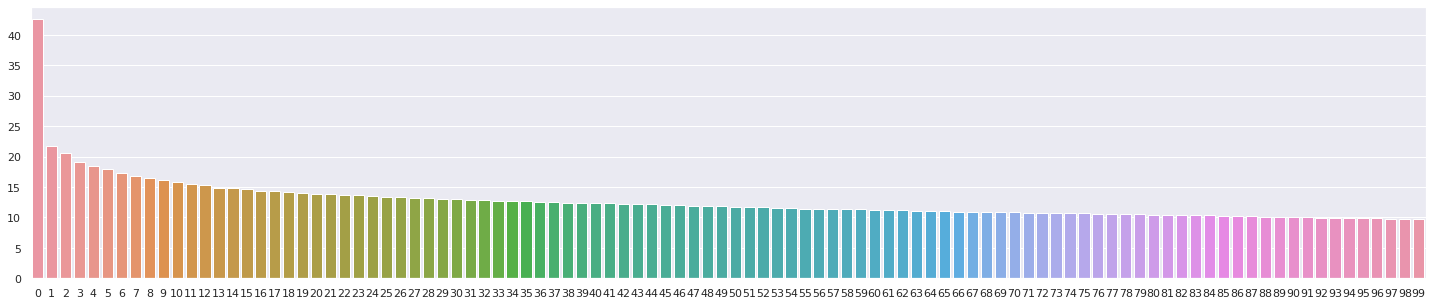

In [76]:
Sigma = svd.singular_values_
V_T = svd.components_.T
plt.figure(figsize=(25, 5))
sns.barplot(x=list(range(len(Sigma))), y=Sigma)


In [63]:
term_topic_matrix = pd.DataFrame(data=V_T,
                                 index=tfidf_vec_text.get_feature_names(),
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])

/home/aurelien/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Mais aussi de faire une forme simple de topic modelling, en associant à chaque composante les termes les plus fréquents leurs correspondants.

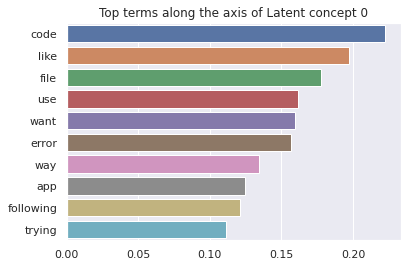

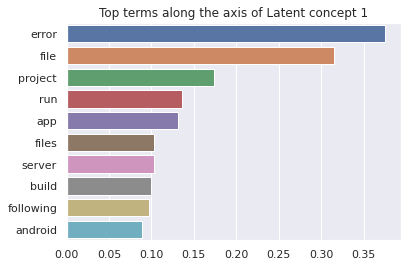

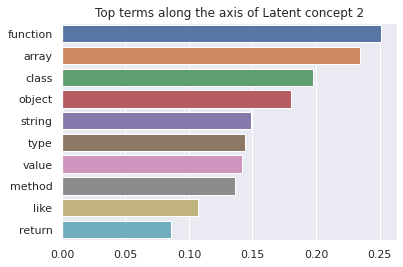

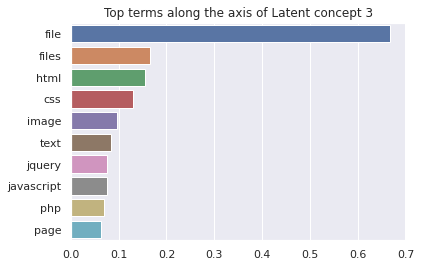

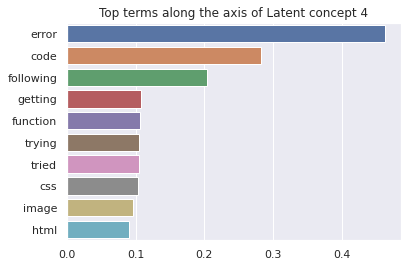

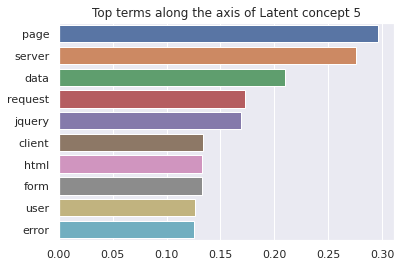

In [64]:
for i in range(6):
    data = term_topic_matrix[f'Latent_concept_{i}']
    data = data.sort_values(ascending=False)
    top_10 = data[:10]
    plt.title(f'Top terms along the axis of Latent concept {i}')
    sns.barplot(x=top_10.values, y=top_10.index);
    plt.show()

Enfin nous entraînons un classifier XGBoost sur les données transformées.

In [66]:

text_train_tf_t = svd.transform(text_train_tf)

time1 = time.time()
clf = XGBClassifier(tree_method="hist")
clf.fit(text_train_tf_t, y_train)
time2 = np.round(time.time() - time1,1)

In [67]:
print(f"Training time: {time2}s")

Training time: 29.7s


In [68]:
text_val_tf_t = svd.transform(text_val_tf)
y_pred = clf.predict(text_val_tf_t)
print("Roc auc for each tag:")
print(list(zip(mlb.classes_, roc_auc_score(y_val, y_pred, average=None))))
print(
    f"Text roc auc macro average: {roc_auc_score(y_val, y_pred, average='macro')}")
print(
    f"Jaccard score sample average: {jaccard_score(y_val, y_pred, average='samples')}")


Roc auc for each tag:
[('.net', 0.5671284457760892), ('android', 0.775833451389496), ('c', 0.6749209808249285), ('c#', 0.5963587965359445), ('c++', 0.6600895454073088), ('css', 0.8150658449467223), ('html', 0.7229313477361474), ('ios', 0.7414678918050411), ('iphone', 0.6312147483836644), ('java', 0.6691400757480395), ('javascript', 0.7023444827060421), ('jquery', 0.7428248323194511), ('node.js', 0.6907318497564489), ('objective-c', 0.6022957245865074), ('php', 0.7257674779350157), ('python', 0.735881308864675)]
Text roc auc macro average: 0.6908748002950951
Jaccard score sample average: 0.3626109537299339


L'entraînement est beaucoup plus court, on passe de 8 minutes à 30s, et les résultats, bien qu'inférieurs, restent relativement comparables à ceux sur les données non transformées.

Si le temps d'entraînement est un réel problème, il peut donc être intéressant d'utiliser LSA pour le réduire grandement tout en conservant des performances raisonnables.